In [38]:
import torch
import torch.nn as nn
from typing import Callable
import numpy as np
import matplotlib.pyplot as plt
from pytorch3dunet.datasets.dsb import TIF_txt_Dataset
from pytorch3dunet.unet3d.model import UNet2D
# import dataloader
from torch.utils.data import DataLoader
import torch.nn.functional as F



In [20]:
class FeatureExtractor(nn.Module):
    def __init__(self, model: nn.Module, layers: list):
        super().__init__()
        self.model = model
        self.layers = layers
        self._features = {layer: torch.empty(0) for layer in layers}
        self.handlers = {layer: None for layer in layers}

        for layer_id in layers:
            layer = dict([*self.model.named_modules()])[layer_id]
            self.handlers[layer_id] = layer.register_forward_hook(self.save_outputs_hook(layer_id))

    def save_outputs_hook(self, layer_id: str) -> Callable:
        def fn(_, input, output):
            self._features[layer_id] = input
        return fn

    def forward(self, x):
        _ = self.model(x)
        return self._features
    
    def remove_handler(self):
        for handler in self.handlers.values():
            handler.remove()

In [ ]:
model = UNet2D(in_channels=1, out_channels=1, final_sigmoid=True)
for nam, module in model.named_modules():
    print(nam)
    print(module)
    print('=====================')

In [3]:
transformer_config = {
    "raw": [
        #{"name": "CropToFixed", "size": [256,256]},
        {"name": "PercentileNormalizer"},
        {"name": "FixedClipping", "max_value": 2},
        {"name": "ToTensor", "expand_dims": True},
    ],
    "label": [
        #{"name": "CropToFixed", "size": [256,256]},
        {"name": "Relabel"},
        {"name": "BlobsToMask", "append_label": False},
        {"name": "ToTensor", "expand_dims": True},
    ]
}

In [4]:
dataset = TIF_txt_Dataset(
    image_dir="/g/kreshuk/talks/data/BBBC039/images",
    mask_dir="/g/kreshuk/talks/data/BBBC039/instance_annotations/instance_labels",
    phase='train',
    transformer_config=transformer_config,
    filenames_path="/g/kreshuk/talks/data/BBBC039/test.txt",
    global_norm=True,
    percentiles=[5,98]
)

In [27]:
model_config = {
    "name": "UNet2D",
    "in_channels": 1,
    "out_channels": 1,
    "layer_order": "bcr",
    "f_maps": [32, 64, 128],
    "final_sigmoid": True,
    "feature_return": True,
    "is_segmentation": True,
    "feature_perturbation": None,
}

In [28]:
dataloader = DataLoader(dataset, batch_size=1, shuffle=False)
#load model
model = UNet2D(**model_config)
#load model state dict
model.load_state_dict(
    torch.load(
        "/g/kreshuk/talks/segmentation_ModelSelection/experiments/BBBC039/BatchNorm/BC_model4/best_checkpoint.pytorch"
    )['model_state_dict']
)

/tmp/ipykernel_273079/316838872.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(


<All keys matched successfully>

In [34]:
for nam, module in model.named_modules():
    print(nam)
    print(module)
    print('=====================')


UNet2D(
  (encoders): ModuleList(
    (0): Encoder(
      (basic_module): DoubleConv(
        (SingleConv1): SingleConv(
          (batchnorm): BatchNorm2d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (ReLU): ReLU(inplace=True)
        )
        (SingleConv2): SingleConv(
          (batchnorm): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (ReLU): ReLU(inplace=True)
        )
      )
    )
    (1): Encoder(
      (pooling): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (basic_module): DoubleConv(
        (SingleConv1): SingleConv(
          (batchnorm): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv): Conv2d(32, 32, kernel_size=(3, 3), stri

In [40]:
layers = ['encoders.2.basic_module.SingleConv2.ReLU', 'decoders.0.basic_module.SingleConv2.ReLU', 'decoders.1.basic_module.SingleConv2.ReLU']
feature_extractor = FeatureExtractor(model, layers)
for i, (image, mask) in enumerate(dataloader):
    print(image.shape)
    print(mask.shape)
    print('=====================')
    image = torch.squeeze(image, dim=-3)
    pred, feats = model(image)
    print(pred.shape)
    print(len(feats))
    print(feats[0].shape)
    print(feats[1].shape)
    print(feats[2].shape)
    print('=====================')
    features = feature_extractor(image)
    feature_extractor.remove_handler()
    print(features['encoders.2.basic_module.SingleConv2.ReLU'][0].shape)
    print(features['decoders.0.basic_module.SingleConv2.ReLU'][0].shape)
    print(features['decoders.1.basic_module.SingleConv2.ReLU'][0].shape)
    print('=====================')
    seg_prob_out = features[layers[0]][0]
    out_shape = mask.shape[3:]
    if seg_prob_out.shape != out_shape:
        seg_prob_out = F.interpolate(seg_prob_out, size=out_shape, mode='bilinear')
    print(seg_prob_out.shape)
    print('=====================')
    print(np.all(np.equal(feats[0].detach().numpy(), features['encoders.2.basic_module.SingleConv2.ReLU'][0].detach().numpy())))
    print(np.all(np.equal(feats[1].detach().numpy(), features['decoders.0.basic_module.SingleConv2.ReLU'][0].detach().numpy())))
    print(np.all(np.equal(feats[2].detach().numpy(), features['decoders.1.basic_module.SingleConv2.ReLU'][0].detach().numpy())))
    break
    

torch.Size([1, 1, 1, 520, 696])
torch.Size([1, 1, 1, 520, 696])
torch.Size([1, 1, 520, 696])
3
torch.Size([1, 128, 130, 174])
torch.Size([1, 64, 260, 348])
torch.Size([1, 32, 520, 696])
torch.Size([1, 128, 130, 174])
torch.Size([1, 64, 260, 348])
torch.Size([1, 32, 520, 696])
torch.Size([1, 128, 520, 696])
True
True
True


In [ ]:
layers = ['encoders.2.basic_module.SingleConv2.ReLU', 'decoders.0.basic_module.SingleConv2.ReLU', 'decoders.1.basic_module.SingleConv2.ReLU']
feature_extractor = FeatureExtractor(model, layers)
for i, (img, label) in enumerate(dataloader):

In [21]:
len(dataset)

48

torch.Size([1, 1, 520, 696]) torch.Size([1, 1, 520, 696])


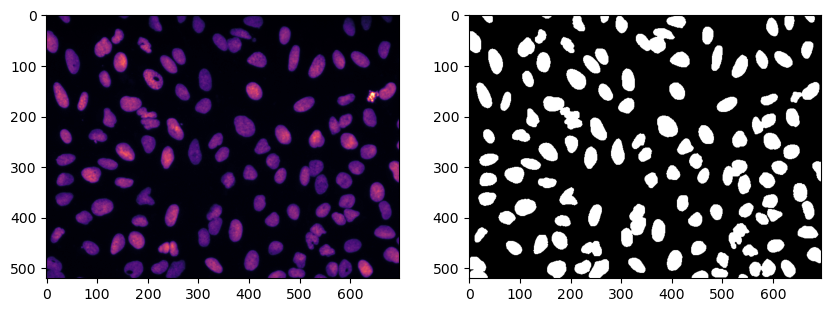

In [22]:
raw, label = dataset[0]
print(raw.shape, label.shape)
_, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(raw.squeeze(), cmap='magma')
axs[1].imshow(label[0].squeeze(), cmap='gray')
plt.show()

In [26]:
layers = [0,1,2]
sample_num = {0 : 100, 1 : 200, 2 : 400}
#labels = labels.as_tensor()
labels = label.squeeze()
sample_dict = {layer:{j:[] for j in range(len(torch.unique(labels)))} for layer in layers}
res_dict = {layer:{j:[] for j in range(len(torch.unique(labels)))} for layer in layers}

for layer in layers:
    for lb in torch.unique(labels):
        lb_idx = torch.nonzero(labels==lb, as_tuple=False).numpy()
        rand_idx = np.random.choice(len(lb_idx), min(len(lb_idx), sample_num[layer]), replace=False)
        sample_dict[layer][int(lb)] = lb_idx[rand_idx]

In [28]:
sample_dict[0].keys()

dict_keys([0, 1])

In [29]:
class_feature_dict = {layer: {j: [] for j in range(
        1+1)} for layer in layers}

In [32]:
class_feature_dict[1].keys()

dict_keys([0, 1])

In [34]:
for i  in range(3):
    if i ==1:
        continue
    print(i)

0
2
